# AMP®-Parkinson's Disease Progression Prediction: LSTM Model

The goal of this Kaggle competition is to: "Use protein and peptide data measurements from Parkinson's Disease patients to predict progression of the disease". This notebook provides the necessary scripts to run the LSTM model.

In [168]:
# First we will import the necessary dependencies
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from scipy import stats

In [169]:
# We import the DataFrame we created
df = pd.read_csv(r'C:\Users\usuario\RecogniChess\Parkinsons\df2_seq.csv')
df.head(15)

,patient_id,visit_id,updrs_1,updrs_2,updrs_3,updrs_4,O00391,O00533,O00584,O14498,...,Q9Y646,Q9Y6R7,P01594,P02792,P32754,P60174,Q13449,Q99683,Q99829,Q9UKV8
0,55,55_00,10.0,6.0,15.0,0.0,11254.30,732430.0,39585.8,41526.9,...,23833.7,18953.5,-666.00,-666.0,-666.0,-666.0,-666.0,-666.0,-666.00,-666.0
1,55,55_06,9.0,9.0,34.0,0.0,13163.60,630465.0,35220.8,41295.0,...,17722.5,16642.7,-666.00,21473.1,-666.0,-666.0,49927.5,121417.0,-666.00,-666.0
2,55,55_12,3.0,3.0,27.0,0.0,15257.60,815083.0,41650.9,39763.3,...,28536.1,19290.9,-666.00,-666.0,-666.0,20088.2,45519.2,121322.0,25589.40,65762.6
3,55,55_36,17.0,11.0,17.0,0.0,13530.80,753832.0,43048.9,43503.6,...,22186.5,21717.1,-666.00,28004.3,78083.4,29641.0,52374.0,114007.0,15790.00,74976.1
4,942,942_06,9.0,8.0,30.0,5.0,11218.70,399518.0,20581.0,31290.9,...,18939.5,15251.2,10007.00,24606.1,41678.4,-666.0,25698.8,127071.0,12277.00,82335.5
5,942,942_12,3.0,5.0,16.0,0.0,6757.32,360858.0,18367.6,14760.7,...,17804.1,12277.0,6317.74,18571.6,43380.0,18918.8,-666.0,92611.1,-666.00,82410.4
6,942,942_24,19.0,18.0,48.0,0.0,-666.00,352722.0,22834.9,23393.1,...,19215.9,14625.6,10438.70,-666.0,41111.7,12938.2,25869.2,113795.0,-666.00,76931.9
7,942,942_48,1.0,2.0,14.0,0.0,11627.80,251820.0,22046.5,26360.5,...,14089.8,16418.5,10717.40,-666.0,35177.7,11087.0,-666.0,124475.0,-666.00,96905.9
8,1517,1517_00,10.0,7.0,25.0,0.0,11648.90,419015.0,35053.8,-666.0,...,19771.6,14699.5,18356.40,25826.9,124675.0,18494.3,32892.8,90539.1,11373.40,55379.8
9,1517,1517_24,21.0,16.0,26.0,0.0,11671.90,438138.0,33740.8,21540.9,...,14642.8,24159.4,13056.40,16164.5,53472.7,13310.1,-666.0,117000.0,12814.30,57261.8


In [170]:
sessions = df['patient_id'].value_counts()

In [171]:
# We will delete rows of people who only had one session
sessions_per_participant = df.groupby('patient_id')['visit_id'].nunique()
multi_session_participants = sessions_per_participant[sessions_per_participant > 1].index.tolist()
df_multi = df[df['patient_id'].isin(multi_session_participants)]

In [172]:
print(f'Shape of the original dataframe:',df.shape)
print(f'Shape of the multisession-only dF',df_multi.shape)

Shape of the original dataframe: (1113, 233)
Shape of the multisession-only dF (1112, 233)


Looks like we only had to delete one participant from the list. That's good.

In [173]:
# Replace -666 values with NaN
df.replace(-666, float("NaN"), inplace=True)

In [174]:
df.head()

,patient_id,visit_id,updrs_1,updrs_2,updrs_3,updrs_4,O00391,O00533,O00584,O14498,...,Q9Y646,Q9Y6R7,P01594,P02792,P32754,P60174,Q13449,Q99683,Q99829,Q9UKV8
0,55,55_00,10.0,6.0,15.0,0.0,11254.3,732430.0,39585.8,41526.9,...,23833.7,18953.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55,55_06,9.0,9.0,34.0,0.0,13163.6,630465.0,35220.8,41295.0,...,17722.5,16642.7,NaN,21473.1,NaN,NaN,49927.5,121417.0,NaN,NaN
2,55,55_12,3.0,3.0,27.0,0.0,15257.6,815083.0,41650.9,39763.3,...,28536.1,19290.9,NaN,NaN,NaN,20088.2,45519.2,121322.0,25589.4,65762.6
3,55,55_36,17.0,11.0,17.0,0.0,13530.8,753832.0,43048.9,43503.6,...,22186.5,21717.1,NaN,28004.3,78083.4,29641.0,52374.0,114007.0,15790.0,74976.1
4,942,942_06,9.0,8.0,30.0,5.0,11218.7,399518.0,20581.0,31290.9,...,18939.5,15251.2,10007.0,24606.1,41678.4,NaN,25698.8,127071.0,12277.0,82335.5


Before we can proceed to normalizing the data, we should inspect the distribution of our data in order to make sure it is distributed like a normal distribution. We will first inspect the four targets (UPDRS) and then we will inspect all the protein counts.

In [175]:
# We use the Shapiro-Wilk test to determine whether the updrs variables are normally distributed
for col in df.iloc[:, 2:6].columns:
    stat, p = stats.shapiro(df[col].dropna())
    print(f'{col}: Statistics={stat:.3f}, p={p:.3f}')

updrs_1: Statistics=0.910, p=0.000
updrs_2: Statistics=0.874, p=0.000
updrs_3: Statistics=0.931, p=0.000
updrs_4: Statistics=0.500, p=0.000


It would be nice to visually inspect each of these four distributions separately by plotting histograms.

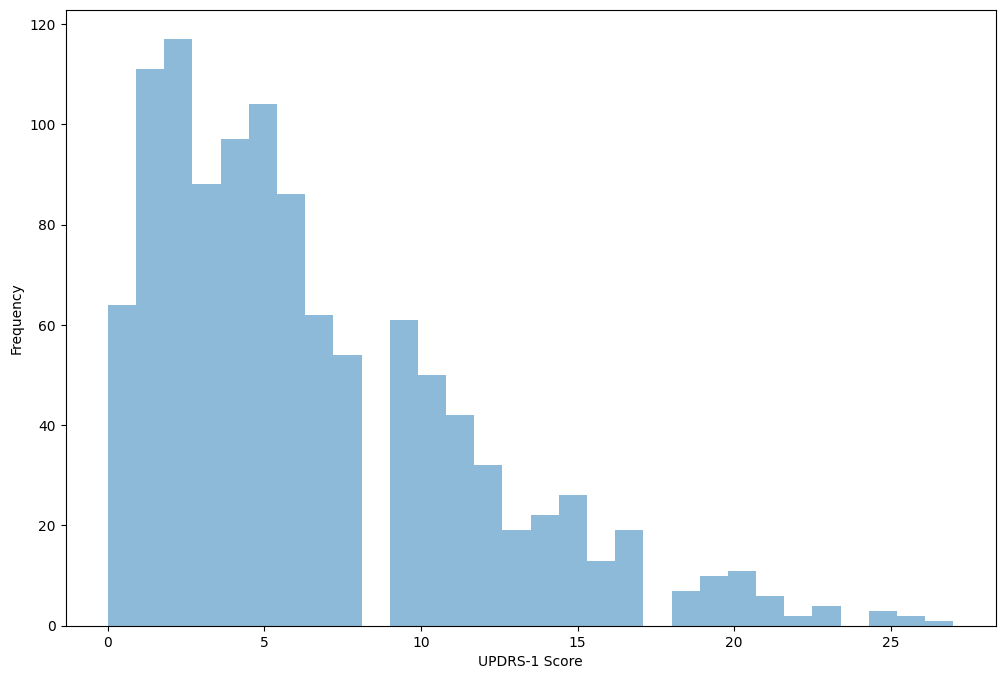

In [176]:
import matplotlib.pyplot as plt

# Plot histograms of the four UPDRS variables
plt.figure(figsize=(12, 8))
plt.hist(df['updrs_1'], bins=30, alpha=0.5, label='UPDRS 1')
plt.xlabel('UPDRS-1 Score')
plt.ylabel('Frequency')
plt.show()


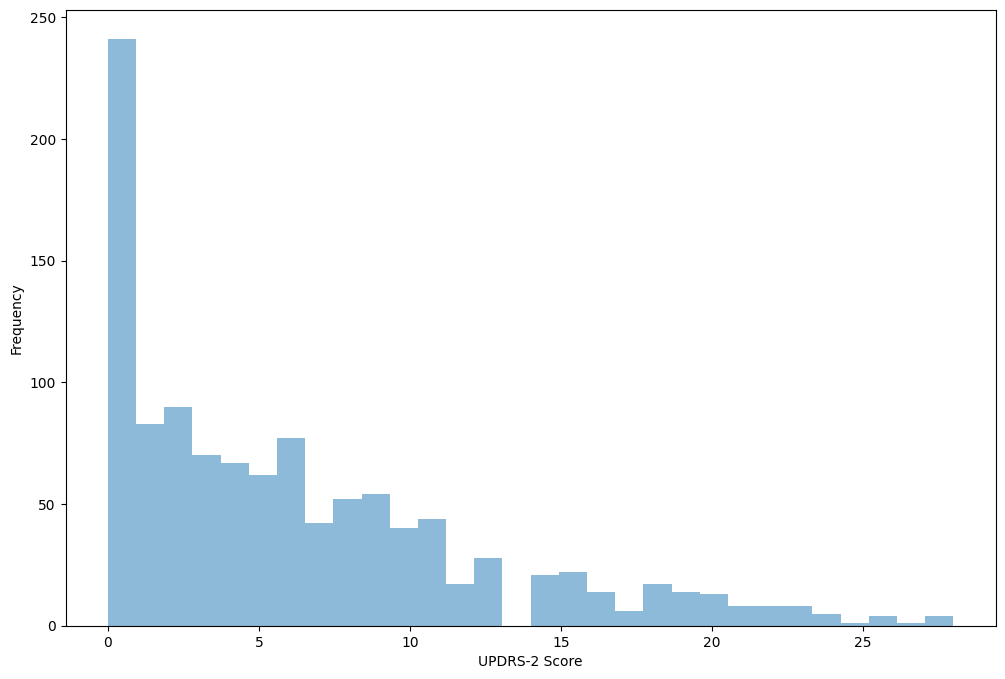

In [177]:
# Plot histograms of the four UPDRS variables
plt.figure(figsize=(12, 8))
plt.hist(df['updrs_2'], bins=30, alpha=0.5, label='UPDRS 1')
plt.xlabel('UPDRS-2 Score')
plt.ylabel('Frequency')
plt.show()

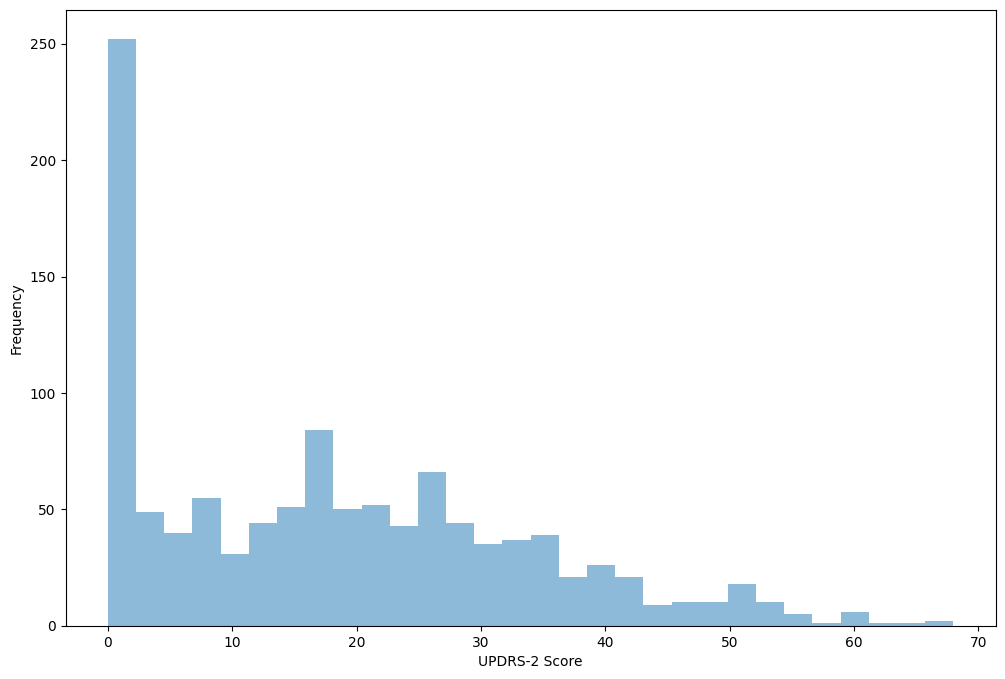

In [178]:
# Plot histograms of the four UPDRS variables
plt.figure(figsize=(12, 8))
plt.hist(df['updrs_3'], bins=30, alpha=0.5, label='UPDRS 1')
plt.xlabel('UPDRS-2 Score')
plt.ylabel('Frequency')
plt.show()

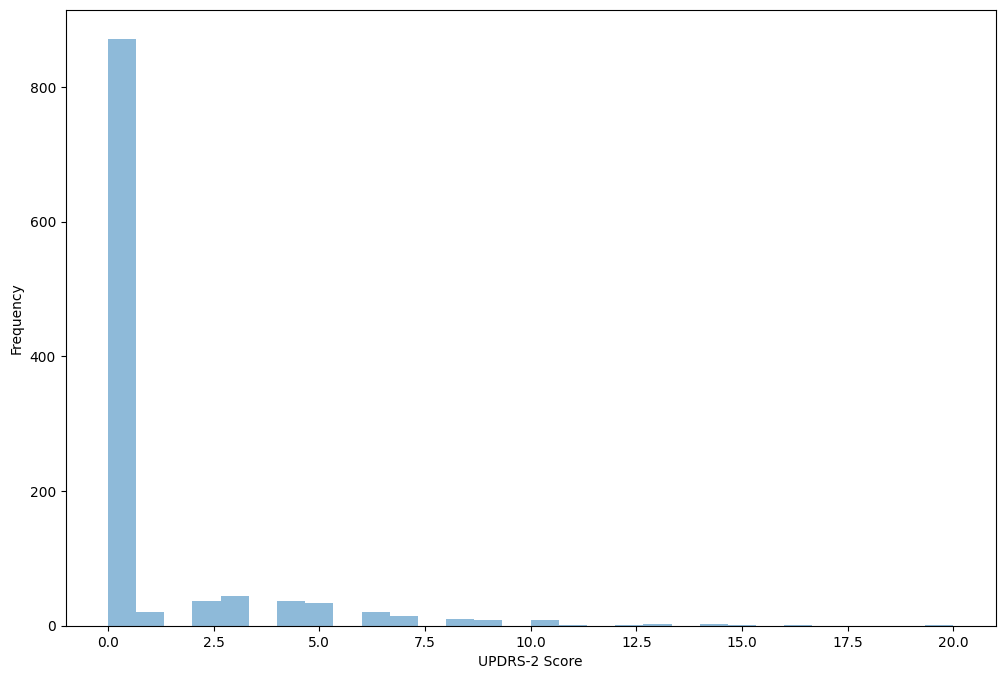

In [179]:
# Plot histograms of the four UPDRS variables
plt.figure(figsize=(12, 8))
plt.hist(df['updrs_4'], bins=30, alpha=0.5, label='UPDRS 1')
plt.xlabel('UPDRS-2 Score')
plt.ylabel('Frequency')
plt.show()

<Axes: xlabel='updrs_1', ylabel='Count'>

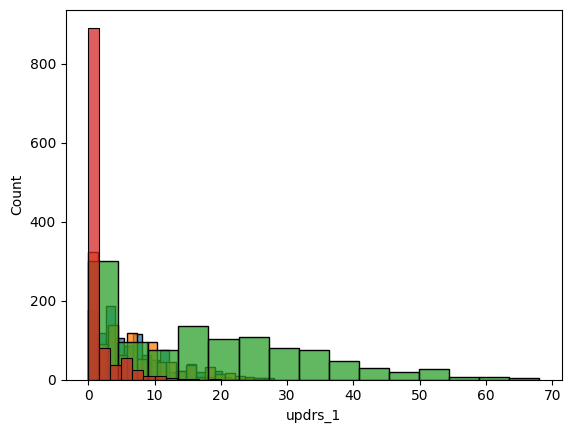

In [180]:
# We can look at all four values together
sns.histplot(data=df, x='updrs_1')
sns.histplot(data=df, x='updrs_2')
sns.histplot(data=df, x='updrs_3')
sns.histplot(data=df, x='updrs_4')

It is clear for the results of the Shapiro-Wilk test that we reject the null hypothesis that the UPDRS columns are normally distributed. Also, from looking at the histogram data we see that the data skews heavily towards towards low counts on the left. The UPDRS-4 column also has a lot of zeroes, so it may not be a super reliable variable to use for prediction.

In [181]:
# Now we will use the Shapiro-Wilk test to determine whether the protein variables are normally distributed
for col in df.iloc[:, 6:].columns:
    stat, p = stats.shapiro(df[col].dropna())
    print(f'{col}: Statistics={stat:.3f}, p={p:.3f}')

O00391: Statistics=0.994, p=0.006
O00533: Statistics=0.967, p=0.000
O00584: Statistics=0.989, p=0.000
O14498: Statistics=0.983, p=0.000
O14773: Statistics=0.982, p=0.000
O14791: Statistics=0.951, p=0.000
O15240: Statistics=0.929, p=0.000
O15394: Statistics=0.990, p=0.000
O43505: Statistics=0.942, p=0.000
O60888: Statistics=0.958, p=0.000
O75144: Statistics=0.984, p=0.000
O75326: Statistics=0.967, p=0.000
O94919: Statistics=0.968, p=0.000
P00441: Statistics=0.971, p=0.000
P00450: Statistics=0.977, p=0.000
P00734: Statistics=0.989, p=0.000
P00736: Statistics=0.985, p=0.000
P00738: Statistics=0.816, p=0.000
P00746: Statistics=0.991, p=0.000
P00747: Statistics=0.994, p=0.000
P00748: Statistics=0.996, p=0.009
P00751: Statistics=0.977, p=0.000
P01008: Statistics=0.989, p=0.000
P01009: Statistics=0.954, p=0.000
P01011: Statistics=0.956, p=0.000
P01019: Statistics=0.987, p=0.000
P01023: Statistics=0.979, p=0.000
P01024: Statistics=0.986, p=0.000
P01031: Statistics=0.983, p=0.000
P01033: Statis

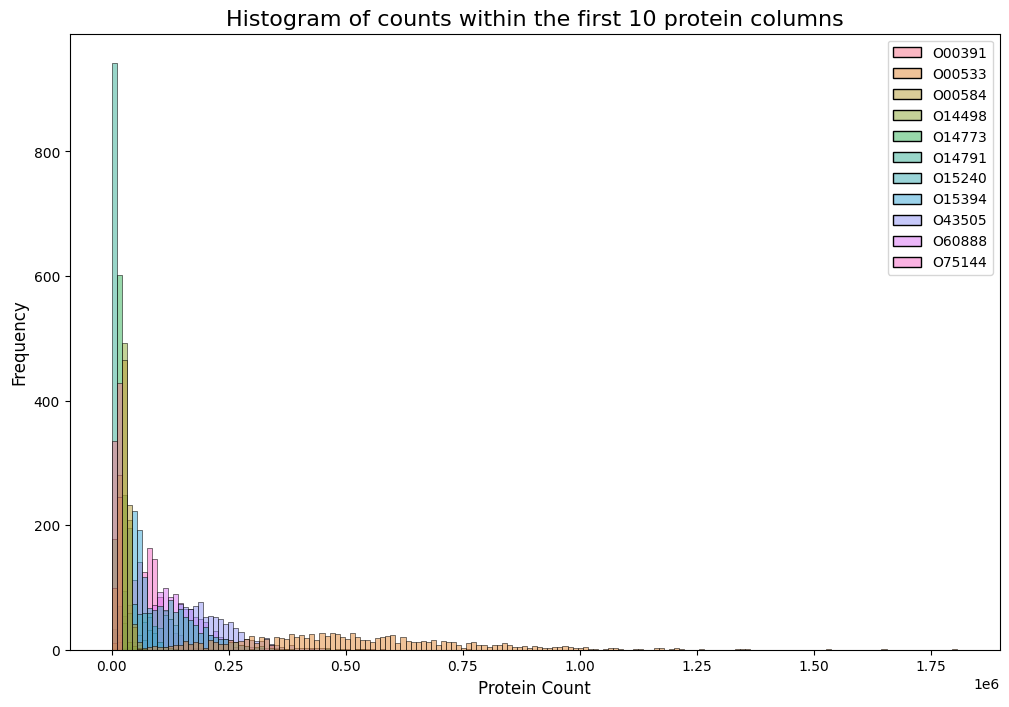

In [182]:
# Select the first 10 protein columns and plot them all together on a histogram
data_to_plot = df.iloc[:, 6:17]

# Create a figure with a single axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the histogram of all columns
sns.histplot(data=data_to_plot, ax=ax, kde=False)

# Set the title and labels
ax.set_title('Histogram of counts within the first 10 protein columns', fontsize=16)
ax.set_xlabel('Protein Count', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Show the plot
plt.show()

We also reject the null hypothesis that the protein columns are normally distributed. Again, the data is heavily skewed towards the low values because these are all counts.

In [183]:
df['updrs_1'] = np.log(df['updrs_1'] + 0.1)
df['updrs_2'] = np.log(df['updrs_2'] + 0.1)
df['updrs_3'] = np.log(df['updrs_3'] + 0.1)
df['updrs_4'] = np.log(df['updrs_4'] + 0.1)

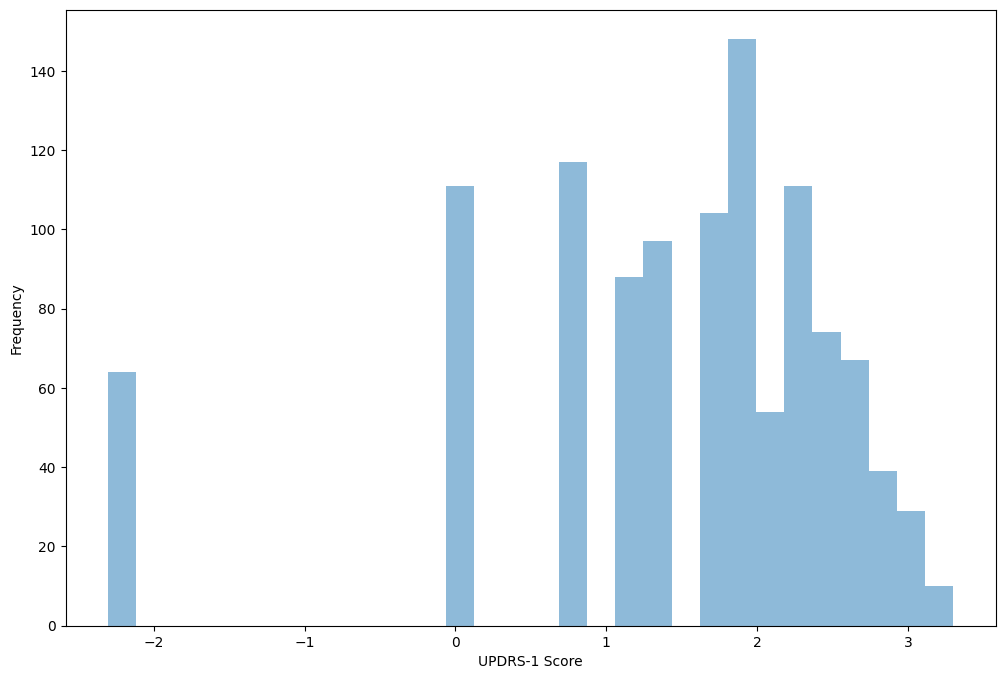

In [184]:
# Plot histograms of the four UPDRS variables
plt.figure(figsize=(12, 8))
plt.hist(df['updrs_1'], bins=30, alpha=0.5, label='UPDRS 1')
plt.xlabel('UPDRS-1 Score')
plt.ylabel('Frequency')
plt.show()

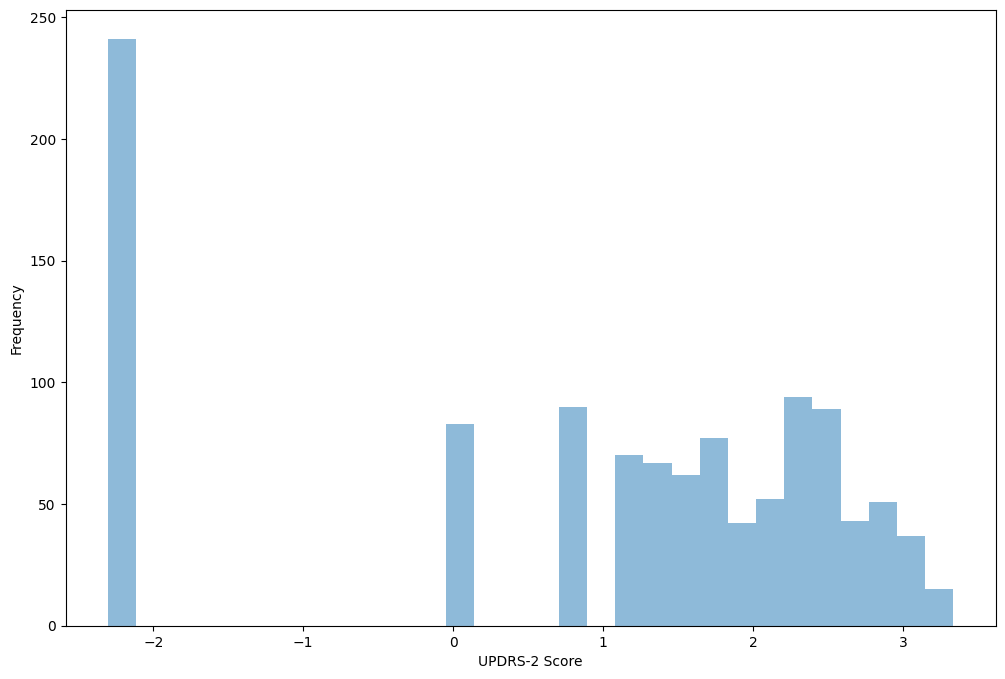

In [185]:
# Plot histograms of the four UPDRS variables
plt.figure(figsize=(12, 8))
plt.hist(df['updrs_2'], bins=30, alpha=0.5, label='UPDRS 2')
plt.xlabel('UPDRS-2 Score')
plt.ylabel('Frequency')
plt.show()

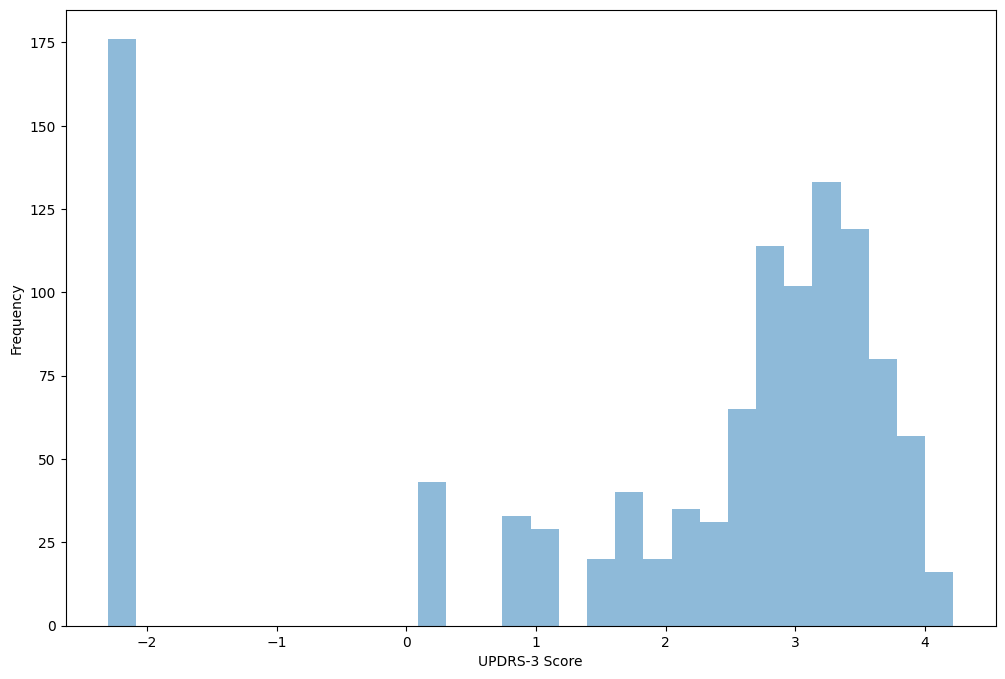

In [186]:
# Plot histograms of the four UPDRS variables
plt.figure(figsize=(12, 8))
plt.hist(df['updrs_3'], bins=30, alpha=0.5, label='UPDRS 3')
plt.xlabel('UPDRS-3 Score')
plt.ylabel('Frequency')
plt.show()

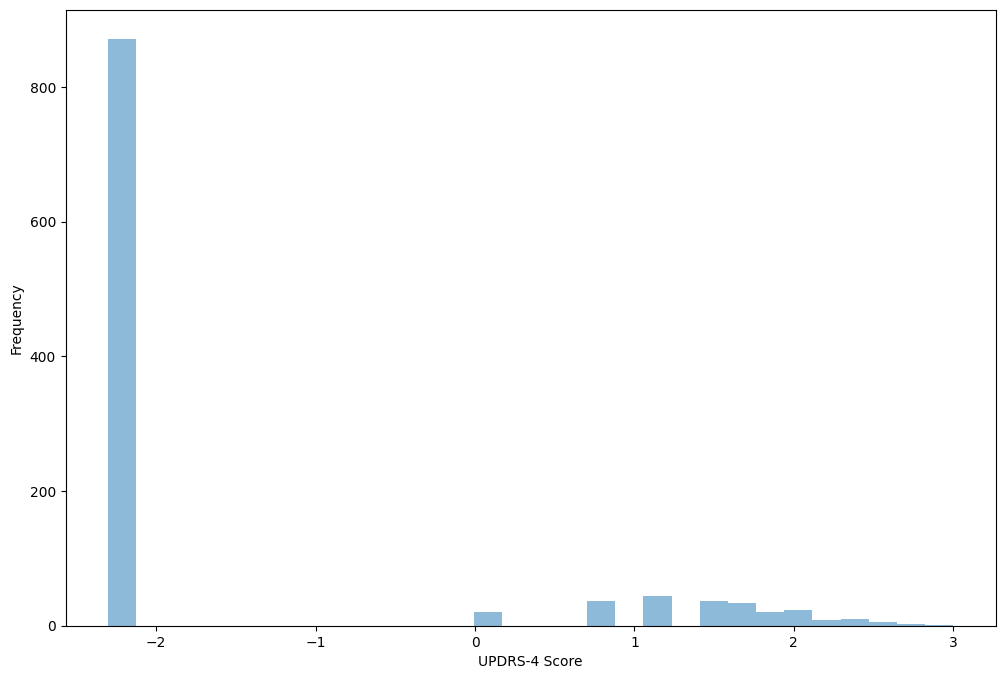

In [187]:
# Plot histograms of the four UPDRS variables
plt.figure(figsize=(12, 8))
plt.hist(df['updrs_4'], bins=30, alpha=0.5, label='UPDRS 4')
plt.xlabel('UPDRS-4 Score')
plt.ylabel('Frequency')
plt.show()

In [188]:
# We use the Shapiro-Wilk test to determine whether the updrs variables are normally distributed
for col in df.iloc[:, 2:6].columns:
    stat, p = stats.shapiro(df[col].dropna())
    print(f'{col}: Statistics={stat:.3f}, p={p:.3f}')

updrs_1: Statistics=0.853, p=0.000
updrs_2: Statistics=0.826, p=0.000
updrs_3: Statistics=0.768, p=0.000
updrs_4: Statistics=0.545, p=0.000


Even after log-transforming, the UPDRS data is still not normal.

In [189]:
import numpy as np

df.iloc[:, 6:17] = np.log(df.iloc[:, 6:17] + 0.1)


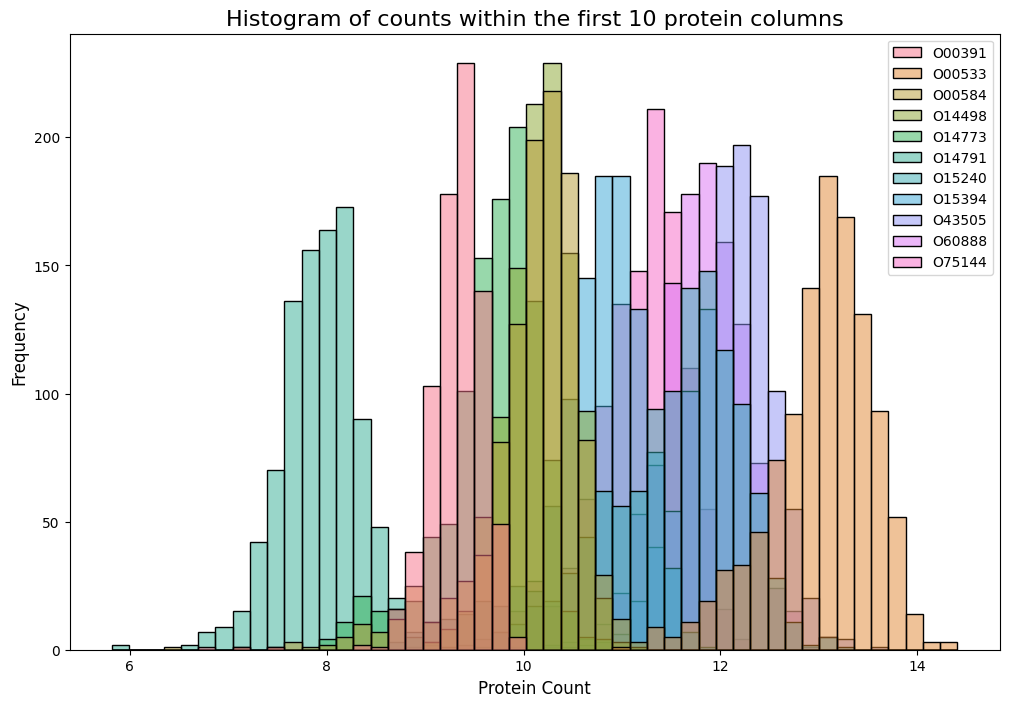

In [190]:
# Select the first 10 protein columns and plot them all together on a histogram
data_to_plot = df.iloc[:, 6:17]

# Create a figure with a single axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the histogram of all columns
sns.histplot(data=data_to_plot, ax=ax, kde=False)

# Set the title and labels
ax.set_title('Histogram of counts within the first 10 protein columns', fontsize=16)
ax.set_xlabel('Protein Count', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Show the plot
plt.show()

In [191]:
# Now we will use the Shapiro-Wilk test to determine whether the protein variables are normally distributed
for col in df.iloc[:, 6:17].columns:
    stat, p = stats.shapiro(df[col].dropna())
    print(f'{col}: Statistics={stat:.3f}, p={p:.3f}')

O00391: Statistics=0.880, p=0.000
O00533: Statistics=0.967, p=0.000
O00584: Statistics=0.859, p=0.000
O14498: Statistics=0.992, p=0.000
O14773: Statistics=0.933, p=0.000
O14791: Statistics=0.982, p=0.000
O15240: Statistics=0.975, p=0.000
O15394: Statistics=0.908, p=0.000
O43505: Statistics=0.987, p=0.000
O60888: Statistics=0.963, p=0.000
O75144: Statistics=0.958, p=0.000


Even after log-transforming, the protein data is still not normal. The solution then is to use MinMax scaler instead of z-scoring. But we will MinMax scale directly on the log-transformed data.

In [192]:
df.iloc[:, 16:] = np.log(df.iloc[:, 16:] + 0.1)

In [193]:
# We will inspect the data to make sure all columns have been log-transformed
df.head()

,patient_id,visit_id,updrs_1,updrs_2,updrs_3,updrs_4,O00391,O00533,O00584,O14498,...,Q9Y646,Q9Y6R7,P01594,P02792,P32754,P60174,Q13449,Q99683,Q99829,Q9UKV8
0,55,55_00,2.312535,1.808289,2.714695,-2.302585,9.328514,13.504123,10.586228,10.634099,...,10.078860,9.849749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55,55_06,2.208274,2.208274,3.529297,-2.302585,9.485218,13.354213,10.469395,10.628499,...,9.782596,9.719733,NaN,9.974561,NaN,NaN,10.818329,11.706987,NaN,NaN
2,55,55_12,1.131402,1.131402,3.299534,-2.302585,9.632840,13.611045,10.637081,10.590702,...,10.258929,9.867394,NaN,NaN,NaN,9.907893,10.725892,11.706204,10.149937,11.093808
3,55,55_36,2.839078,2.406945,2.839078,-2.302585,9.512731,13.532925,10.670094,10.680601,...,10.007244,9.985860,NaN,10.240117,11.265534,10.296917,10.866167,11.644016,9.667138,11.224926
4,942,942_06,2.208274,2.091864,3.404525,1.629241,9.325346,12.898014,9.932128,10.351086,...,9.849010,9.632420,9.21105,10.110754,10.637741,NaN,10.154203,11.752502,9.415491,11.318559


Before we can apply the MinMax scaling, we need to divide the data into training, validation and test splits.

In [194]:
import random
random.seed(13)

# Create a list of unique participant IDs
patient_ids = df['patient_id'].unique()

# We will shuffle the participants
np.random.shuffle(patient_ids)

# Split participant IDs into training, validation, and test sets
train_size = 0.7
val_size = 0.2
test_size = 0.1
train_patient_ids, val_patient_ids, test_patient_ids = np.split(patient_ids, [int(train_size * len(patient_ids)), int((train_size + val_size) * len(patient_ids))])

# Create training, validation, and test dataframes
train_df = df[df['patient_id'].isin(train_patient_ids)]
val_df = df[df['patient_id'].isin(val_patient_ids)]
test_df = df[df['patient_id'].isin(test_patient_ids)]

In [195]:
print(train_df.shape)
train_df.head()

(770, 233)


,patient_id,visit_id,updrs_1,updrs_2,updrs_3,updrs_4,O00391,O00533,O00584,O14498,...,Q9Y646,Q9Y6R7,P01594,P02792,P32754,P60174,Q13449,Q99683,Q99829,Q9UKV8
4,942,942_06,2.208274,2.091864,3.404525,1.629241,9.325346,12.898014,9.932128,10.351086,...,9.849010,9.632420,9.211050,10.110754,10.637741,NaN,10.154203,11.752502,9.415491,11.318559
5,942,942_12,1.131402,1.629241,2.778819,-2.302585,8.818396,12.796240,9.818349,9.599730,...,9.787190,9.415491,8.751133,9.829394,10.677756,9.847917,NaN,11.436165,NaN,11.319468
6,942,942_24,2.949688,2.895912,3.873282,-2.302585,NaN,12.773436,10.036050,10.060201,...,9.863499,9.590536,9.253285,NaN,10.624050,9.467947,10.160812,11.642155,NaN,11.250677
7,942,942_48,0.095310,0.741937,2.646175,-2.302585,9.361163,12.436470,10.000914,10.179626,...,9.553214,9.706170,9.279633,NaN,10.468170,9.313538,NaN,11.731861,NaN,11.481497
15,2660,2660_00,2.091864,2.208274,3.404525,-2.302585,NaN,13.270489,10.249199,10.305055,...,10.151523,9.797627,9.288588,NaN,11.545839,9.571847,10.306259,11.371038,NaN,10.915948


In [196]:
print(val_df.shape)
val_df.head()

(237, 233)


,patient_id,visit_id,updrs_1,updrs_2,updrs_3,updrs_4,O00391,O00533,O00584,O14498,...,Q9Y646,Q9Y6R7,P01594,P02792,P32754,P60174,Q13449,Q99683,Q99829,Q9UKV8
0,55,55_00,2.312535,1.808289,2.714695,-2.302585,9.328514,13.504123,10.586228,10.634099,...,10.078860,9.849749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55,55_06,2.208274,2.208274,3.529297,-2.302585,9.485218,13.354213,10.469395,10.628499,...,9.782596,9.719733,NaN,9.974561,NaN,NaN,10.818329,11.706987,NaN,NaN
2,55,55_12,1.131402,1.131402,3.299534,-2.302585,9.632840,13.611045,10.637081,10.590702,...,10.258929,9.867394,NaN,NaN,NaN,9.907893,10.725892,11.706204,10.149937,11.093808
3,55,55_36,2.839078,2.406945,2.839078,-2.302585,9.512731,13.532925,10.670094,10.680601,...,10.007244,9.985860,NaN,10.240117,11.265534,10.296917,10.866167,11.644016,9.667138,11.224926
8,1517,1517_00,2.312535,1.960095,3.222868,-2.302585,9.362976,12.945662,10.464642,NaN,...,9.892007,9.595576,9.817739,10.159176,11.733466,9.825223,10.401012,11.413538,9.339041,10.921972


In [197]:
print(test_df.shape)
test_df.head()

(106, 233)


,patient_id,visit_id,updrs_1,updrs_2,updrs_3,updrs_4,O00391,O00533,O00584,O14498,...,Q9Y646,Q9Y6R7,P01594,P02792,P32754,P60174,Q13449,Q99683,Q99829,Q9UKV8
41,4923,4923_12,1.629241,1.410987,3.261935,1.131402,9.057268,12.507085,10.284281,9.746214,...,9.716833,9.997005,9.436543,NaN,NaN,9.508235,9.571491,11.570336,NaN,11.281402
42,4923,4923_24,2.091864,0.095310,-2.302585,-2.302585,9.431794,13.021393,9.868182,10.214386,...,10.262437,9.927995,9.419701,9.143061,NaN,9.561638,10.146959,11.493484,NaN,10.889108
43,4923,4923_36,2.949688,1.960095,3.139833,1.960095,9.313970,13.099895,10.297507,9.976738,...,10.083490,10.082562,9.453404,9.782094,NaN,9.575539,9.837011,11.278669,NaN,11.459384
44,4923,4923_48,0.095310,1.960095,2.493205,-2.302585,6.772941,12.697199,10.344484,9.754576,...,9.944946,9.927092,9.463509,9.600448,NaN,9.358053,9.627385,11.544483,NaN,11.526050
45,4923,4923_60,1.629241,0.095310,1.629241,-2.302585,9.366780,11.907202,10.407563,9.870050,...,9.439776,10.227699,9.234516,NaN,11.133549,8.992479,9.041137,11.360406,NaN,11.477298


In [198]:
# Initialize scaler
scaler = MinMaxScaler()

# Fit scaler on training data
scaler.fit(train_df.iloc[:, 3:])

# Transform training and validation data separately
train_df.iloc[:, 3:] = scaler.transform(train_df.iloc[:, 3:])
val_df.iloc[:, 3:] = scaler.transform(val_df.iloc[:, 3:])
test_df.iloc[:, 3:] = scaler.transform(test_df.iloc[:, 3:])

C:\Users\usuario\AppData\Local\Temp\ipykernel_19744\1873421915.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.iloc[:, 3:] = scaler.transform(train_df.iloc[:, 3:])
C:\Users\usuario\AppData\Local\Temp\ipykernel_19744\1873421915.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.iloc[:, 3:] = scaler.transform(val_df.iloc[:, 3:])
C:\Users\usuario\AppData\Local\Temp\ipykernel_19744\1873421915.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [199]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [200]:
print(train_df.shape)
train_df.head()

(770, 233)


,patient_id,visit_id,updrs_1,updrs_2,updrs_3,updrs_4,O00391,O00533,O00584,O14498,...,Q9Y646,Q9Y6R7,P01594,P02792,P32754,P60174,Q13449,Q99683,Q99829,Q9UKV8
0,942,942_06,2.208274,0.779385,0.874846,0.741392,0.782034,0.548224,0.758893,0.629688,...,0.739119,0.421260,0.387814,0.803281,0.435199,NaN,0.691295,0.694584,0.562482,0.705866
1,942,942_12,1.131402,0.697336,0.778931,0.000000,0.596143,0.514084,0.734570,0.251853,...,0.718619,0.361049,0.215286,0.680671,0.449871,0.790335,NaN,0.472778,NaN,0.706163
2,942,942_24,2.949688,0.921988,0.946702,0.000000,NaN,0.506435,0.781109,0.483410,...,0.743923,0.409635,0.403657,NaN,0.430179,0.635783,0.693163,0.617212,NaN,0.683718
3,942,942_48,0.095310,0.539966,0.758598,0.000000,0.795167,0.393400,0.773598,0.543466,...,0.641034,0.441731,0.413541,NaN,0.373025,0.572977,NaN,0.680111,NaN,0.759028
4,2660,2660_00,2.091864,0.800031,0.874846,0.000000,NaN,0.673171,0.826675,0.606540,...,0.839430,0.467116,0.416900,NaN,0.768157,0.678044,0.734273,0.427113,NaN,0.574504


In [201]:
print(val_df.shape)
val_df.head()

(237, 233)


,patient_id,visit_id,updrs_1,updrs_2,updrs_3,updrs_4,O00391,O00533,O00584,O14498,...,Q9Y646,Q9Y6R7,P01594,P02792,P32754,P60174,Q13449,Q99683,Q99829,Q9UKV8
0,55,55_00,2.312535,0.729091,0.769101,0.0,0.783196,0.751544,0.898723,0.772007,...,0.815335,0.481583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55,55_06,2.208274,0.800031,0.893972,0.0,0.840657,0.701256,0.873747,0.769191,...,0.717096,0.445495,NaN,0.743931,NaN,NaN,0.879010,0.662670,NaN,NaN
2,55,55_12,1.131402,0.609041,0.858751,0.0,0.894787,0.787411,0.909594,0.750184,...,0.875045,0.486480,NaN,NaN,NaN,0.814730,0.852882,0.662122,0.881640,0.632535
3,55,55_36,2.839078,0.835267,0.788168,0.0,0.850745,0.761205,0.916651,0.795392,...,0.791588,0.519362,NaN,0.859654,0.665382,0.972965,0.892531,0.618517,0.671837,0.675316
4,1517,1517_00,2.312535,0.756015,0.846999,0.0,0.795832,0.564208,0.872731,NaN,...,0.753376,0.411034,0.615399,0.824382,0.836952,0.781104,0.761055,0.456913,0.529260,0.576469


In [202]:
print(test_df.shape)
test_df.head()

(106, 233)


,patient_id,visit_id,updrs_1,updrs_2,updrs_3,updrs_4,O00391,O00533,O00584,O14498,...,Q9Y646,Q9Y6R7,P01594,P02792,P32754,P60174,Q13449,Q99683,Q99829,Q9UKV8
0,4923,4923_12,1.629241,0.658627,0.852988,0.647518,0.683734,0.417087,0.834174,0.325515,...,0.695289,0.522456,0.472402,NaN,NaN,0.652170,0.526591,0.566855,NaN,0.693742
1,4923,4923_24,2.091864,0.425283,0.000000,0.000000,0.821067,0.589612,0.745223,0.560945,...,0.876208,0.503301,0.466084,0.381584,NaN,0.673891,0.689247,0.512968,NaN,0.565747
2,4923,4923_36,2.949688,0.756015,0.834271,0.803778,0.777863,0.615945,0.837002,0.441439,...,0.816870,0.546203,0.478727,0.660059,NaN,0.679546,0.601641,0.362347,NaN,0.751814
3,4923,4923_48,0.095310,0.756015,0.735149,0.000000,-0.153895,0.480861,0.847044,0.329720,...,0.770930,0.503050,0.482517,0.580902,NaN,0.591084,0.542390,0.548728,NaN,0.773565
4,4923,4923_60,1.629241,0.425283,0.602711,0.000000,0.797227,0.215857,0.860529,0.387789,...,0.603419,0.586488,0.396616,NaN,0.616989,0.442387,0.376687,0.419658,NaN,0.757659


Fantastic. The data has been log-transformed, split into train-val-test splits, and MinMax scaled. We are now ready to create the input arrays to the model.

In [203]:
# We will begin the process of tokenizing the data by replacing the NaN values with -1
train_df.fillna(-1, inplace=True)
val_df.fillna(-1, inplace=True)
test_df.fillna(-1, inplace=True)

In [204]:
# Create a list of unique protein labels
protein_labels = train_df.columns[6:]

# Create a dictionary mapping protein labels to integer tokens
protein_dict = {label: i+1 for i, label in enumerate(protein_labels)}

In [205]:
protein_dict

{'O00391': 1,
 'O00533': 2,
 'O00584': 3,
 'O14498': 4,
 'O14773': 5,
 'O14791': 6,
 'O15240': 7,
 'O15394': 8,
 'O43505': 9,
 'O60888': 10,
 'O75144': 11,
 'O75326': 12,
 'O94919': 13,
 'P00441': 14,
 'P00450': 15,
 'P00734': 16,
 'P00736': 17,
 'P00738': 18,
 'P00746': 19,
 'P00747': 20,
 'P00748': 21,
 'P00751': 22,
 'P01008': 23,
 'P01009': 24,
 'P01011': 25,
 'P01019': 26,
 'P01023': 27,
 'P01024': 28,
 'P01031': 29,
 'P01033': 30,
 'P01034': 31,
 'P01042': 32,
 'P01344': 33,
 'P01591': 34,
 'P01608': 35,
 'P01621': 36,
 'P01717': 37,
 'P01780': 38,
 'P01833': 39,
 'P01834': 40,
 'P01857': 41,
 'P01859': 42,
 'P01860': 43,
 'P01861': 44,
 'P01876': 45,
 'P01877': 46,
 'P02452': 47,
 'P02647': 48,
 'P02649': 49,
 'P02652': 50,
 'P02655': 51,
 'P02656': 52,
 'P02671': 53,
 'P02675': 54,
 'P02679': 55,
 'P02747': 56,
 'P02748': 57,
 'P02749': 58,
 'P02750': 59,
 'P02751': 60,
 'P02753': 61,
 'P02760': 62,
 'P02763': 63,
 'P02765': 64,
 'P02766': 65,
 'P02768': 66,
 'P02774': 67,
 'P0

In [206]:
# Create a list of unique protein labels
protein_labels = train_df.columns[6:]

# Create a dictionary mapping protein labels to integer tokens
protein_dict = {label: i+1 for i, label in enumerate(protein_labels)}

# Rename columns with protein integer tokens
for df in [train_df, val_df, test_df]:
    protein_cols = df.columns[6:]  # get only the protein count columns
    protein_cols = protein_cols.map(protein_dict)  # map protein labels to integer tokens
    df.rename(columns=protein_dict, inplace=True)  # rename columns with integer tokens
    df[protein_cols] = df[protein_cols].fillna(-1)  # replace NAs with -1


In [207]:
print(train_df.shape)
train_df.head()

,patient_id,visit_id,updrs_1,updrs_2,updrs_3,updrs_4,1,2,3,4,...,218,219,220,221,222,223,224,225,226,227
0,942,942_06,2.208274,0.779385,0.874846,0.741392,0.782034,0.548224,0.758893,0.629688,...,0.739119,0.421260,0.387814,0.803281,0.435199,-1.000000,0.691295,0.694584,0.562482,0.705866
1,942,942_12,1.131402,0.697336,0.778931,0.000000,0.596143,0.514084,0.734570,0.251853,...,0.718619,0.361049,0.215286,0.680671,0.449871,0.790335,-1.000000,0.472778,-1.000000,0.706163
2,942,942_24,2.949688,0.921988,0.946702,0.000000,-1.000000,0.506435,0.781109,0.483410,...,0.743923,0.409635,0.403657,-1.000000,0.430179,0.635783,0.693163,0.617212,-1.000000,0.683718
3,942,942_48,0.095310,0.539966,0.758598,0.000000,0.795167,0.393400,0.773598,0.543466,...,0.641034,0.441731,0.413541,-1.000000,0.373025,0.572977,-1.000000,0.680111,-1.000000,0.759028
4,2660,2660_00,2.091864,0.800031,0.874846,0.000000,-1.000000,0.673171,0.826675,0.606540,...,0.839430,0.467116,0.416900,-1.000000,0.768157,0.678044,0.734273,0.427113,-1.000000,0.574504


In [208]:
print(val_df.shape)
val_df.head()

,patient_id,visit_id,updrs_1,updrs_2,updrs_3,updrs_4,1,2,3,4,...,218,219,220,221,222,223,224,225,226,227
0,55,55_00,2.312535,0.729091,0.769101,0.0,0.783196,0.751544,0.898723,0.772007,...,0.815335,0.481583,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,55,55_06,2.208274,0.800031,0.893972,0.0,0.840657,0.701256,0.873747,0.769191,...,0.717096,0.445495,-1.000000,0.743931,-1.000000,-1.000000,0.879010,0.662670,-1.000000,-1.000000
2,55,55_12,1.131402,0.609041,0.858751,0.0,0.894787,0.787411,0.909594,0.750184,...,0.875045,0.486480,-1.000000,-1.000000,-1.000000,0.814730,0.852882,0.662122,0.881640,0.632535
3,55,55_36,2.839078,0.835267,0.788168,0.0,0.850745,0.761205,0.916651,0.795392,...,0.791588,0.519362,-1.000000,0.859654,0.665382,0.972965,0.892531,0.618517,0.671837,0.675316
4,1517,1517_00,2.312535,0.756015,0.846999,0.0,0.795832,0.564208,0.872731,-1.000000,...,0.753376,0.411034,0.615399,0.824382,0.836952,0.781104,0.761055,0.456913,0.529260,0.576469


In [209]:
print(test_df.shape)
test_df.head()

(106, 233)


,patient_id,visit_id,updrs_1,updrs_2,updrs_3,updrs_4,1,2,3,4,...,218,219,220,221,222,223,224,225,226,227
0,4923,4923_12,1.629241,0.658627,0.852988,0.647518,0.683734,0.417087,0.834174,0.325515,...,0.695289,0.522456,0.472402,-1.000000,-1.000000,0.652170,0.526591,0.566855,-1.0,0.693742
1,4923,4923_24,2.091864,0.425283,0.000000,0.000000,0.821067,0.589612,0.745223,0.560945,...,0.876208,0.503301,0.466084,0.381584,-1.000000,0.673891,0.689247,0.512968,-1.0,0.565747
2,4923,4923_36,2.949688,0.756015,0.834271,0.803778,0.777863,0.615945,0.837002,0.441439,...,0.816870,0.546203,0.478727,0.660059,-1.000000,0.679546,0.601641,0.362347,-1.0,0.751814
3,4923,4923_48,0.095310,0.756015,0.735149,0.000000,-0.153895,0.480861,0.847044,0.329720,...,0.770930,0.503050,0.482517,0.580902,-1.000000,0.591084,0.542390,0.548728,-1.0,0.773565
4,4923,4923_60,1.629241,0.425283,0.602711,0.000000,0.797227,0.215857,0.860529,0.387789,...,0.603419,0.586488,0.396616,-1.000000,0.616989,0.442387,0.376687,0.419658,-1.0,0.757659


In [218]:
# Group by patient and count the number of unique visits
num_visits_train = train_df.groupby('patient_id')['visit_id'].nunique() - 1

# Multiply by 227 to get target sequence length
seq_length_train = num_visits_train * 227

# Group by patient and count the number of unique visits
num_visits_val = val_df.groupby('patient_id')['visit_id'].nunique() - 1

# Multiply by 227 to get target sequence length
seq_length_val = num_visits_val * 227

# Group by patient and count the number of unique visits
num_visits_test = test_df.groupby('patient_id')['visit_id'].nunique() - 1

# Multiply by 227 to get target sequence length
seq_length_test = num_visits_test * 227

In [220]:
print(f'The number of patients in the train set is:',len(seq_length_train))
print(f'The number of patients in the val set is:',len(seq_length_val))
print(f'The number of patients in the test set is:',len(seq_length_test))

The number of patients in the train set is: 173
The number of patients in the val set is: 50
The number of patients in the test set is: 25


In [227]:
# Let's take a look at the different sequence lengths
seq_length_train[:10]

patient_id
942      681
2660     908
5027     681
5036    1135
5178    1362
5645    1135
5742     454
6211    1362
6420     908
7051     681
Name: visit_id, dtype: int64